<a href="https://colab.research.google.com/github/dragosconst/Anomaly-Detection/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/kaggle_ag_dataset.zip" -d "/content/data/"

Archive:  /content/drive/MyDrive/kaggle_ag_dataset.zip
  inflating: /content/data/test.csv  
  inflating: /content/data/train.csv  


# Imports and global constants

In [4]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 35.7 MB/s 
     |████████████████████████████████| 895 kB 52.4 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [37]:
#----------- func typing -----------#
from typing import List, Tuple, Dict, Union, Iterable
#----------- base libs -------------#
import time
import csv
import random
import os
import math
import copy
#----------- progress bar ----------#
from tqdm import tqdm
#----------- pickle ----------------#
import pickle
#----------- scikit ----------------#
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split
#----------- pytorch ---------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
#----------- numpy -----------------#
import numpy as np
#----------- huggingface -----------#
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, AutoConfig, AdamW, TrainingArguments, Trainer, pipeline, BertModel, BertConfig,\
                         BertForMaskedLM
#----------- plot libs -------------#
import seaborn as sn
import matplotlib.pyplot as plt

sn.set_style("darkgrid")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
train_path = '/content/data/train.csv'
test_path = '/content/data/test.csv'

Let's peek at the data:


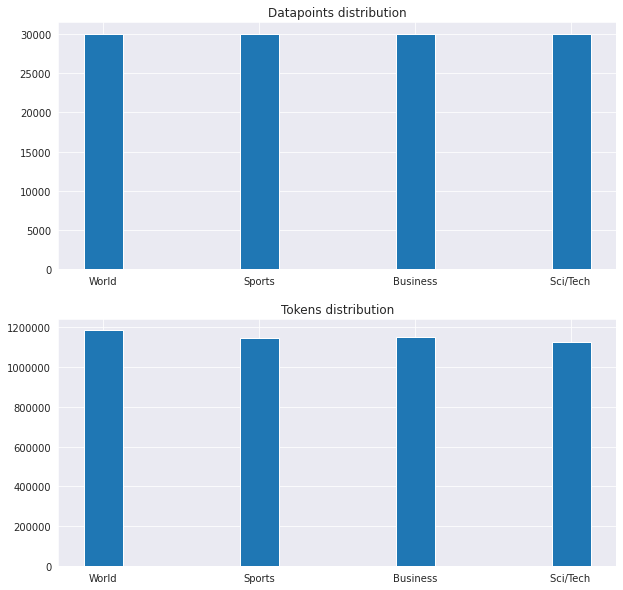

In [10]:
class_bins = np.zeros(4)
class_tokens = np.zeros(4)
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    class_bins[int(cls) - 1] += 1
    title_words = len(title.split(" "))
    desc_words = len(desc.split(" ")) 
    class_tokens[int(cls) - 1] += title_words + desc_words
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].bar(["World", "Sports", "Business", "Sci/Tech "], class_bins, width = 0.25)
ax[0].set_title("Datapoints distribution")
ax[1].bar(["World", "Sports", "Business", "Sci/Tech "], class_tokens, width = 0.25)
ax[1].ticklabel_format(style='plain', axis='y')
ax[1].set_title("Tokens distribution")
plt.show()

Huh, the dataset looks very balanced. In this case, we will arbitrarily choose one class to serve as our normal class for training, and the rest will be considered outlier classes.

In [7]:
normal_class = 2 # we will detect Anomalies on Sports
outlier_classes = [1, 3, 4]

# I will concatenate titles and descriptions, maybe we could try differentiating them
# at training time to compare results
normal_class_instances = []
with open(train_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    if int(cls) == normal_class:
      normal_class_instances.append(title)
      normal_class_instances.append(desc)

In [8]:
inliers_test = []
outliers_test = []
with open(test_path, "r") as f:
  reader = csv.reader(f)
  for idx, row in enumerate(reader):
    if idx == 0:
      continue
    cls, title, desc = row
    if int(cls) == normal_class:
      inliers_test.append(title)
      inliers_test.append(desc)
    else:
      outliers_test.append(title)
      outliers_test.append(desc)

In [9]:
MASK_TOK_ID = AutoTokenizer.from_pretrained("bert-base-cased").mask_token_id # apparently, [MASK] has token id 103 in regular BERT

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

# Datasets and Dataloaders

In [11]:
class NormalSet(Dataset):
  def __init__(self, class_instances: List, masked_per: float=0.15):
    self.class_instances = class_instances
    self.masked_per = masked_per
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
  def __len__(self):
    return len(self.class_instances)
  def __getitem__(self, idx):
    if not isinstance(idx, Iterable):
      idx = [idx]
    data = []
    targets = []
    for i in idx:
      data_raw = self.class_instances[i]
      tokenized_bert = self.tokenizer(data_raw, add_special_tokens=True, max_length=100, padding='max_length',
                                return_tensors='pt', truncation=True)
      # ignore padding 
      at_mask = tokenized_bert["attention_mask"]
      relevant_tokens_num = len(at_mask[at_mask == 1]) - 2 # [CLS] and [SEP] shouldn't be masked, probably
      # get mask
      masked_tokens_num = math.floor(relevant_tokens_num * self.masked_per)
      masks = np.random.randint(low=1, high=relevant_tokens_num + 1, size=masked_tokens_num) # [CLS] and [SEP] should only be the first and last tokens
      data_tokens = []
      targets_tokens = []
      # mask the inputs and build the new data and targets
      for idx, tok_id in enumerate(tokenized_bert["input_ids"][0]):
        tok_id = tok_id.item() # tok_ids end up as being one-element tensors because pytorch always returns a tensor when indexing a tensor, for some reason
        gt_tok = -100 # ignore non-masked
        if idx in masks:
          gt_tok = tok_id
          tok_id = MASK_TOK_ID
        targets_tokens.append(gt_tok)
        data_tokens.append(tok_id)
      data_tokens = torch.as_tensor(data_tokens)
      targets_tokens = torch.as_tensor(targets_tokens)

      data.append(data_tokens)
      targets.append(targets_tokens)
    return torch.stack(data), torch.stack(targets)

In [12]:
class TestSet(Dataset):
  def __init__(self, inliers: List, outliers: List):
    self.inliers = inliers
    self.outliers = outliers
    self.class_instances = self.inliers + self.outliers

    self.labels = len(self.inliers) * [0] + len(self.outliers) * [1]

    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

  def __len__(self):
    return len(self.class_instances)

  def __getitem__(self, idx):
    text = self.class_instances[idx]
    label = self.labels[idx]

    tokenized_bert = self.tokenizer(text, add_special_tokens=True, max_length=100, padding='max_length',
                              return_tensors='pt', truncation=True)
    
    return tokenized_bert["input_ids"], torch.tensor([label])

In [ ]:
def collate_fn(data):
  tokens = []
  labels = []
  for datum in data:
    tokens.append(datum[0])
    labels.append(datum[1][0])
  return torch.stack(tokens), torch.cat(labels)

In [13]:
dataset = NormalSet(normal_class_instances)
ds_train, ds_valid = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

BATCH_SIZE=48
dl_train = DataLoader(
    ds_train, batch_size=BATCH_SIZE, shuffle=True
)
dl_valid = DataLoader(
  ds_valid, batch_size=BATCH_SIZE, shuffle=False
)

In [14]:
test_set = TestSet(inliers_test, outliers_test)

BATCH_SIZE=48
dl_test = DataLoader(
    test_set, batch_size=BATCH_SIZE
)


# Create the model

In [15]:
vocab_size = len(AutoTokenizer.from_pretrained("bert-base-cased"))

In [16]:
class AnomalyDetectionModel(nn.Module):
  def __init__(self, num_hidden_layer: int=6, num_attention_heads: int=8, intermediate_size: int=1536, hidden_size: int=384):
    super(AnomalyDetectionModel, self).__init__()

    # Get the Transformer from the huggingface server
    config = BertConfig.from_pretrained(
        "bert-base-cased", num_hidden_layers=num_hidden_layer, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size, hidden_size=hidden_size)
    self.transformer = BertForMaskedLM(config)

  def forward(self, x, labels):
    # x is B x T, where B is batch size and T is max tokens num
    # Get output from Transformer.
    out = self.transformer(x, labels=labels)
    # # out is B x T x BE, where BE is BERT encoding hidden size
    # # for each BE output that is a mask, we need to pass it through the linear layer
    # scores = []
    # for idb, batch in enumerate(x):
    #   for idt, token in enumerate(batch):
    #     if token.item() == MASK_TOK_ID:
    #       score = self.cls_scores(out[idb, idt])
    #       scores.append(score)
    return out

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate our model and move it to GPU
model = AnomalyDetectionModel().to(device)

# Print the model paramters
print("Model's parameters: ")
num_params = 0
for n, p in model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

# Training the model


In [ ]:
# Defining the optimizer and loss function
optim = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Defining the train and evaluation functions.
def train(model, optim, dl_train):
    epoch_loss = 0
    model.train()
    preds = []
    gt = []

    times = []
    acc_loss = 0
    for idx, batch in enumerate(dl_train):
        # get rough estimate of eta
        beg = time.time()

        inputs, labels = batch
        inputs = inputs.squeeze(1) # extra dimension because of my dataset implementation Iterable quirk
        labels = labels.squeeze(1)
        # Move data to GPU
        inputs = inputs.to(device)
        # mask_labels = mask_labels.to(device)
        labels = labels.to(device).long()
        flattened_inputs = inputs.flatten()
        mask_indices = (inputs == MASK_TOK_ID).nonzero()
        acc_loss += len(flattened_inputs[flattened_inputs == MASK_TOK_ID])

        output = model(inputs.to(device), labels=labels)
        # Calculate the loss and backpropagate
        # loss = loss_fn(output, labels)
        loss = output.loss
        loss.backward()
        # Update weights
        if acc_loss >= 200:
            acc_loss = 0
            optim.step()
            optim.zero_grad()

        final = time.time()
        times.append(final - beg)

        epoch_loss += loss.item()
        
        # print a message every 100 batches
        if idx % 100 == 0:
            print(f"Loss is {loss}, time left = {(sum(times) / len(times) * (len(dl_train.dataset) - (idx + 1) * BATCH_SIZE) / BATCH_SIZE) / 60} minutes.")

    # Average the epoch losses
    epoch_loss /= len(dl_train)

    return epoch_loss


"""
broken function, doesn't do what we want it to do
"""
@torch.inference_mode()
def evaluate(model, optim, dl_valid):
    test_loss = 0
    model.eval()
    preds = []
    gt = []

    for idx, batch in enumerate(dl_valid):
        inputs, labels = batch

        inputs = inputs.squeeze(1) # extra dimension because of my dataset implementation Iterable quirk
        labels = labels.squeeze(1)

        inputs = inputs.to(device)
        labels = labels.to(device).long()

        output = model(inputs, labels=labels)

        # test_loss += loss_fn(output, labels).item()
        test_loss += output.loss.detach().item()


    test_loss /= len(dl_valid)

    return test_loss

In [ ]:
# Train loop
num_epochs = 50
best_val_loss = None

pbar = tqdm(range(num_epochs))
train_losses = []
val_losses = []


for e in tqdm(range(num_epochs)):
    train_loss = train(model, optim, dl_train)
    val_loss = evaluate(model, optim, dl_valid)

    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch: {e+1}, t_loss: {round(train_loss, 2)}, v_loss: {round(val_loss, 2)}")

    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './best_bert_model.pt')

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
ax[0].plot(range(num_epochs), train_losses, color='orange', label='train loss')
ax[0].plot(range(num_epochs), val_losses, color='blue', label='valid loss')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: ignored

# Evaluate the model


In [22]:
# def calculate_normality_score(model, input_ids):
#   probs = np.array([])

#   # Mask each token and calculate the probability of the correct label
#   for tok_id in range(1, len(input_ids[0])):
#     labels  = copy.deepcopy(input_ids)

#     if labels[0][tok_id].item() == 3:
#       break

#     old_tok = input_ids[0][tok_id].item()
#     input_ids[0][tok_id] = tokenizer.mask_token_id
#     labels[input_ids != tokenizer.mask_token_id] = -100

#     outputs = model(input_ids, labels=labels)

#     scores = outputs.logits
#     softmax = torch.nn.Softmax(dim=-1)

#     probs = np.append(probs, softmax(scores[0][tok_id])[old_tok].item())

#     input_ids[0][tok_id] = torch.tensor([old_tok])
#   print(np.mean(probs))
#   return np.mean(probs)

In [26]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def multiple_masked_tokens_normality_score(model, input_ids, num_comp):
  global tokenizer
  
  probs = np.array([])
  elim_tokens = np.array([101, 102, 0])

  tok_ids = np.array([i for i in range(len(input_ids[0])) if input_ids[0][i].item() not in elim_tokens])
  random.shuffle(tok_ids)
  partion = np.array_split(tok_ids, num_comp)

  for comp in partion:
    labels  = copy.deepcopy(input_ids)

    old_tokens = np.array([input_ids[0][tok_id].item() for tok_id in comp])
    input_ids[0][comp] = tokenizer.mask_token_id
    labels[input_ids != tokenizer.mask_token_id] = -100

    outputs = model(input_ids, labels=labels)

    scores = outputs.logits
    softmax = torch.nn.Softmax(dim=-1)

    for tok_id, old_tok in zip(comp, old_tokens):
      probs = np.append(probs, softmax(scores[0][tok_id])[old_tok].item())
      input_ids[0][tok_id] = torch.tensor([old_tok])

  return np.mean(probs)

In [23]:
model = AnomalyDetectionModel().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/trained_bert_sports_agnews.pt"))
model = model.to(device)

In [ ]:
# scores = []
# corect_labels = []
# for idx, batch in enumerate(dl_test):
#   texts, labels = batch
#   for i in range(2):
#     text = texts[i]
#     label = labels[i]
#     scores.append(calculate_normality_score(model, text))
#     corect_labels.append(label.item())
#   print(f"Finish {idx} / {len(dl_test)} batches")
#   if idx > 10:
#     break
#   #corect_labels += labels.tolist()

In [27]:
scores = []
corect_labels = []
for idx, batch in enumerate(dl_test):
  texts, labels = batch

  texts = texts.to(device)
  labels = labels.to(device)
  for text in tqdm(texts):
    scores.append(multiple_masked_tokens_normality_score(model, text, 6))
    
  print(f"Finished {idx} / {len(dl_test)} batches")
  corect_labels += labels.tolist()

100%|██████████| 48/48 [00:03<00:00, 12.66it/s]


Finished 0 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.87it/s]


Finished 1 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.77it/s]


Finished 2 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.85it/s]


Finished 3 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.12it/s]


Finished 4 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.19it/s]


Finished 5 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.20it/s]


Finished 6 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 7 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.04it/s]


Finished 8 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 9 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.12it/s]


Finished 10 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.03it/s]


Finished 11 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.15it/s]


Finished 12 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 13 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 14 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 15 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 16 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.16it/s]


Finished 17 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.15it/s]


Finished 18 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 19 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.21it/s]


Finished 20 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 21 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.29it/s]


Finished 22 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 23 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.22it/s]


Finished 24 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.17it/s]


Finished 25 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.16it/s]


Finished 26 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 27 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.14it/s]


Finished 28 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.25it/s]


Finished 29 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.21it/s]


Finished 30 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 31 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 32 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 33 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.03it/s]


Finished 34 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.85it/s]


Finished 35 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 36 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 37 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.23it/s]


Finished 38 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.78it/s]


Finished 39 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 40 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.87it/s]


Finished 41 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 42 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.90it/s]


Finished 43 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 44 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 45 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.74it/s]


Finished 46 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.85it/s]


Finished 47 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.86it/s]


Finished 48 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 49 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.89it/s]


Finished 50 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.89it/s]


Finished 51 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 52 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 53 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.15it/s]


Finished 54 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 55 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.04it/s]


Finished 56 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 57 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 58 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 59 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.15it/s]


Finished 60 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 61 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 62 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 63 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 64 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 65 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 66 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.90it/s]


Finished 67 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.04it/s]


Finished 68 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.14it/s]


Finished 69 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 70 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 71 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 72 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 73 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 74 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 75 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 76 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 77 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 78 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 79 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.93it/s]


Finished 80 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.85it/s]


Finished 81 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.72it/s]


Finished 82 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.02it/s]


Finished 83 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.77it/s]


Finished 84 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.81it/s]


Finished 85 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 86 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 87 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 88 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.63it/s]


Finished 89 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 90 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.86it/s]


Finished 91 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 92 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 93 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 94 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 95 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 96 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.90it/s]


Finished 97 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 98 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 99 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 100 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 101 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 102 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 103 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.94it/s]


Finished 104 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.18it/s]


Finished 105 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 106 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 107 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 108 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 109 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.22it/s]


Finished 110 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 111 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.04it/s]


Finished 112 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.78it/s]


Finished 113 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 114 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 115 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 116 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.83it/s]


Finished 117 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 118 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 119 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 120 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.76it/s]


Finished 121 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 122 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 123 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.84it/s]


Finished 124 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 125 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 126 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.94it/s]


Finished 127 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 128 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.83it/s]


Finished 129 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 130 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 131 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 132 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 133 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 134 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 135 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 136 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 137 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 138 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 139 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.18it/s]


Finished 140 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.59it/s]


Finished 141 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.83it/s]


Finished 142 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.79it/s]


Finished 143 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.04it/s]


Finished 144 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.22it/s]


Finished 145 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 146 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.80it/s]


Finished 147 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 148 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 149 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.94it/s]


Finished 150 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.79it/s]


Finished 151 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.82it/s]


Finished 152 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 153 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 154 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 155 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 156 / 317 batches


100%|██████████| 48/48 [00:04<00:00,  9.81it/s]


Finished 157 / 317 batches


100%|██████████| 48/48 [00:05<00:00,  8.87it/s]


Finished 158 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 159 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.02it/s]


Finished 160 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 161 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 162 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 163 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.03it/s]


Finished 164 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.28it/s]


Finished 165 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 166 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.87it/s]


Finished 167 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.90it/s]


Finished 168 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 169 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 170 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 171 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 172 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 173 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.94it/s]


Finished 174 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.87it/s]


Finished 175 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 176 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.80it/s]


Finished 177 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.87it/s]


Finished 178 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 179 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 180 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 181 / 317 batches


100%|██████████| 48/48 [00:04<00:00,  9.88it/s]


Finished 182 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 183 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.67it/s]


Finished 184 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 185 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.03it/s]


Finished 186 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 187 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.85it/s]


Finished 188 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.15it/s]


Finished 189 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.18it/s]


Finished 190 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.95it/s]


Finished 191 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 192 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 193 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.16it/s]


Finished 194 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 195 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 196 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 197 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.23it/s]


Finished 198 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 199 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 200 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 201 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 202 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 203 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.85it/s]


Finished 204 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.14it/s]


Finished 205 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 206 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 207 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 208 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 209 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 210 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 211 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 212 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 213 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 214 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.89it/s]


Finished 215 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 216 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 217 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 218 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.02it/s]


Finished 219 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 220 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 221 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 222 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.02it/s]


Finished 223 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 224 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 225 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 226 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 227 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.03it/s]


Finished 228 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.59it/s]


Finished 229 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.05it/s]


Finished 230 / 317 batches


100%|██████████| 48/48 [00:06<00:00,  7.83it/s]


Finished 231 / 317 batches


100%|██████████| 48/48 [00:07<00:00,  6.60it/s]


Finished 232 / 317 batches


100%|██████████| 48/48 [00:05<00:00,  8.01it/s]


Finished 233 / 317 batches


100%|██████████| 48/48 [00:05<00:00,  8.09it/s]


Finished 234 / 317 batches


100%|██████████| 48/48 [00:06<00:00,  7.45it/s]


Finished 235 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.79it/s]


Finished 236 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 237 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.14it/s]


Finished 238 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 239 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.03it/s]


Finished 240 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 241 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 242 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 243 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.83it/s]


Finished 244 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.94it/s]


Finished 245 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.89it/s]


Finished 246 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.80it/s]


Finished 247 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.16it/s]


Finished 248 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.78it/s]


Finished 249 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 250 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 251 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 252 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.92it/s]


Finished 253 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 254 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.89it/s]


Finished 255 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.04it/s]


Finished 256 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 257 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.84it/s]


Finished 258 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.90it/s]


Finished 259 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 260 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 261 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.08it/s]


Finished 262 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 263 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 264 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.94it/s]


Finished 265 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 266 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 267 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.13it/s]


Finished 268 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 269 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 270 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.12it/s]


Finished 271 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.21it/s]


Finished 272 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.99it/s]


Finished 273 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 274 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.02it/s]


Finished 275 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.93it/s]


Finished 276 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.83it/s]


Finished 277 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 278 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 279 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.97it/s]


Finished 280 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.89it/s]


Finished 281 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.93it/s]


Finished 282 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.16it/s]


Finished 283 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.80it/s]


Finished 284 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.77it/s]


Finished 285 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.67it/s]


Finished 286 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 287 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.81it/s]


Finished 288 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.12it/s]


Finished 289 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.96it/s]


Finished 290 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.88it/s]


Finished 291 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 292 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.90it/s]


Finished 293 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 294 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.89it/s]


Finished 295 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.18it/s]


Finished 296 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.79it/s]


Finished 297 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 298 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.83it/s]


Finished 299 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.90it/s]


Finished 300 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.98it/s]


Finished 301 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 302 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.82it/s]


Finished 303 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.06it/s]


Finished 304 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.11it/s]


Finished 305 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.10it/s]


Finished 306 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.91it/s]


Finished 307 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.05it/s]


Finished 308 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.09it/s]


Finished 309 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.00it/s]


Finished 310 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.01it/s]


Finished 311 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.07it/s]


Finished 312 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 13.21it/s]


Finished 313 / 317 batches


100%|██████████| 48/48 [00:04<00:00, 11.80it/s]


Finished 314 / 317 batches


100%|██████████| 48/48 [00:03<00:00, 12.87it/s]


Finished 315 / 317 batches


100%|██████████| 32/32 [00:02<00:00, 12.87it/s]

Finished 316 / 317 batches


In [29]:
corect_labels = [c[0] for c in corect_labels]

In [30]:
print(scores)
print(corect_labels)

[0.11036138094023044, 0.30694382034750933, 0.27700935381905695, 0.26343711806883024, 0.16771953675489307, 0.23906731599490064, 0.07590975975824676, 0.23344297226532854, 0.2676055333504337, 0.3462564587235273, 0.0002094240472464056, 0.395363991185017, 0.43492664838049677, 0.524501361132215, 0.47081398811600855, 0.4609830439993467, 0.44493970033441393, 0.5353257447919425, 0.08166747039681752, 0.4184786752127882, 0.17681045815921748, 0.6376890670120096, 0.27942119717640296, 0.4963686728351604, 0.2660824309520346, 0.4556427346226428, 0.3790549099110357, 0.2350529087930274, 0.3663274128750495, 0.33573939217571946, 0.4803468626916583, 0.41328581341456255, 0.13336998202326608, 0.24786169980819064, 0.019562019390390616, 0.44601465301408705, 0.09882972215304367, 0.303598075748952, 0.46674539912475244, 0.5785144669859127, 0.30201794167320867, 0.5081363685288922, 0.012543816342561817, 0.34740585461002466, 0.15444804320577532, 0.4796344525557721, 0.040772282769665935, 0.2351369634479592, 0.1981449

In [32]:
score = roc_auc_score(corect_labels,scores)
score

0.21783626500461678

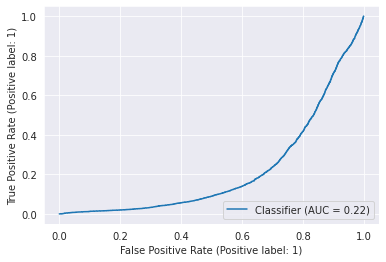

In [39]:
RocCurveDisplay.from_predictions(corect_labels,scores)

In [ ]:
# import copy
# from transformers import BertForMaskedLM, BertTokenizerFast
# import torch

# # tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# # model = AnomalyDetectionModel()
# # model.load_state_dict(torch.load("trained_bert_sports_agnews.pt"))
# model1 = copy.deepcopy(model)
# model1.to("cpu")

# model2 = BertForMaskedLM.from_pretrained('bert-base-cased')
# text = "Dr. Mario Roederer and Adam Treister at Stanford University wrote FlowJo, Mac OS X analysis software for flow cytometers, high-speed, automated microscopes. Today, some 15,000 to 20,000 cytometers in use are Mac based. Aug 3"
# inputs  =  tokenizer(text,  return_tensors="pt", add_special_tokens = True, truncation=True, pad_to_max_length = True,
#                                          return_attention_mask = True,  max_length=100)
# input_ids = inputs['input_ids']
# print(tokenizer.convert_ids_to_tokens(input_ids[0]))
# labels  = copy.deepcopy(input_ids) #this is the part I changed
# tok_id = 14
# print(tokenizer.convert_ids_to_tokens([input_ids[0][tok_id]]))
# old_tok = input_ids[0][tok_id].item()
# input_ids[0][tok_id] = tokenizer.mask_token_id
# labels[input_ids != tokenizer.mask_token_id] = -100 

# outputs = model1(input_ids, labels=labels)
# # outputs =  model2(input_ids = input_ids, attention_mask = inputs['attention_mask'] , token_type_ids=inputs['token_type_ids'] , labels=labels)
# loss = outputs.loss
# scores = outputs.logits
# print('loss',loss)
# print(tokenizer.convert_ids_to_tokens([old_tok]))
# pred = torch.argmax( scores[0][tok_id]).item()
# logSoftmax = torch.nn.LogSoftmax(dim=1)
# softmax = torch.nn.Softmax()
# NLLLos = torch.nn.NLLLoss()
# print("predicted token:", pred, tokenizer.convert_ids_to_tokens([pred])  )
# print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][tok_id], 0)), torch.tensor([pred]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))
# print(softmax(scores[0][tok_id])[pred])
# print(softmax(scores[0][tok_id])[old_tok])
# # print(NLLLos( logSoftmax(torch.unsqueeze(scores[0][16], 0)), torch.tensor([old_tok]))) #the same as F.cross_entropy(scores.view(-1, tokenizer.vocab_size), labels.view(-1))